In [443]:
import time
import os
import itertools
from datetime import datetime, timezone, timedelta

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from collections import OrderedDict
from linearmodels.panel import BetweenOLS, FirstDifferenceOLS, PanelOLS, PooledOLS, RandomEffects, compare
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Default settings
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style="darkgrid")
random_seed = 42

In [3]:
df_target = pd.read_csv('data/output_objects_borough_cluster_year.csv')
print(df_target.head())
df_target.shape

    REGION OBJECT_CLUSTER  YEAR      AVG_DAY
0  Abcoude      HB_Medium  2010   -12.277174
1  Abcoude      HB_Medium  2011 -1156.000000
2  Abcoude      HB_Medium  2015  1198.987730
3  Abcoude       HB_Small  2010  5960.581105
4  Abcoude       HB_Small  2011  6650.036107


(808, 4)

In [4]:
# Checking regions in Dataset
df_target.REGION.unique()

array(['Abcoude', 'Amstelveen', 'Centrum', 'Diemen', 'Heemstede',
       'Muiden', 'Nieuw-West', 'Noord', 'Oost', 'Ouder-Amstel',
       'Undefined', 'West', 'Westpoort', 'Zuid', 'Zuidoost'], dtype=object)

In [5]:
# Checking clusters in Dataset
df_target.OBJECT_CLUSTER.unique()

array(['HB_Medium', 'HB_Small', 'ZB_Medium', 'ZB_Small', 'HB_Large',
       'ZB_Large', 'ZB_Mega', 'HB_Mega'], dtype=object)

In [6]:
# Removing Undefined, Abcoude, and Muiden from the dataset because they are not in scope
df_target = df_target.loc[~df_target.REGION.isin(['Undefined', 'Abcoude', 'Muiden'])]
df_target

,REGION,OBJECT_CLUSTER,YEAR,AVG_DAY
33,Amstelveen,HB_Large,2010,9.711431e+05
34,Amstelveen,HB_Large,2011,5.485785e+05
35,Amstelveen,HB_Large,2012,5.430256e+05
36,Amstelveen,HB_Large,2013,1.169675e+06
37,Amstelveen,HB_Large,2014,9.206660e+05
...,...,...,...,...
803,Zuidoost,ZB_Small,2015,2.390724e+05
804,Zuidoost,ZB_Small,2016,2.412996e+05
805,Zuidoost,ZB_Small,2017,2.383869e+05
806,Zuidoost,ZB_Small,2018,2.485874e+05


In [7]:
# Adding distinction Households and businesses
df_target['OBJ_TYPE'] = df_target.OBJECT_CLUSTER.str[:2]
df_target

,REGION,OBJECT_CLUSTER,YEAR,AVG_DAY,OBJ_TYPE
33,Amstelveen,HB_Large,2010,9.711431e+05,HB
34,Amstelveen,HB_Large,2011,5.485785e+05,HB
35,Amstelveen,HB_Large,2012,5.430256e+05,HB
36,Amstelveen,HB_Large,2013,1.169675e+06,HB
37,Amstelveen,HB_Large,2014,9.206660e+05,HB
...,...,...,...,...,...
803,Zuidoost,ZB_Small,2015,2.390724e+05,ZB
804,Zuidoost,ZB_Small,2016,2.412996e+05,ZB
805,Zuidoost,ZB_Small,2017,2.383869e+05,ZB
806,Zuidoost,ZB_Small,2018,2.485874e+05,ZB


In [8]:
# Showing total consumption per segment per year
df_clusters = pd.pivot_table(df_target, index='OBJECT_CLUSTER', columns='YEAR', values='AVG_DAY', aggfunc=np.sum)
df_clusters

YEAR,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
OBJECT_CLUSTER,,,,,,,,,,
HB_Large,1.245527e+06,6.772757e+05,6.539058e+05,1.227155e+06,1.048685e+06,4.196684e+05,1.627200e+05,3.730103e+05,4.642298e+05,2.588850e+05
HB_Medium,4.822970e+06,4.225227e+06,4.158474e+06,4.769568e+06,4.613109e+06,3.897769e+06,3.437077e+06,3.739457e+06,4.608229e+06,1.815709e+06
HB_Mega,NaN,-1.239605e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HB_Small,1.521535e+07,2.445093e+07,2.538478e+07,2.446329e+07,2.521586e+07,2.772667e+07,2.907671e+07,2.892355e+07,2.880822e+07,1.468813e+07
ZB_Large,5.125274e+06,5.680012e+06,5.930347e+06,5.760120e+06,6.270713e+06,6.532994e+06,5.866960e+06,6.465899e+06,6.454721e+06,3.901874e+06
ZB_Medium,8.260146e+06,8.288112e+06,8.381299e+06,8.418720e+06,8.521256e+06,8.721767e+06,8.978204e+06,9.135537e+06,9.827991e+06,5.139670e+06
ZB_Mega,NaN,2.779865e+05,NaN,2.438123e+05,2.019424e+05,3.885641e+05,3.564800e+05,2.274708e+05,1.164754e+05,2.424117e+05
ZB_Small,3.338875e+06,3.333631e+06,3.689951e+06,3.573860e+06,3.803241e+06,3.856744e+06,4.035675e+06,3.906533e+06,3.892891e+06,2.045344e+06


In [9]:
# Showing total consumption per object type per year
df_types = pd.pivot_table(df_target, index='OBJ_TYPE', columns='YEAR', values='AVG_DAY', aggfunc=np.sum)
df_types

YEAR,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
OBJ_TYPE,,,,,,,,,,
HB,2.128384e+07,2.922947e+07,3.019716e+07,3.046001e+07,3.087765e+07,3.204411e+07,3.267650e+07,3.303602e+07,3.388068e+07,1.676273e+07
ZB,1.672430e+07,1.757974e+07,1.800160e+07,1.799651e+07,1.879715e+07,1.950007e+07,1.923732e+07,1.973544e+07,2.029208e+07,1.132930e+07


In [10]:
# Creating series with full consumption from old excel file
total_households = pd.Series(data={2013: 47e6, 2014: 48e6, 2015: 48.1e6, 2016: 49.2e6, 2017: 48.7e6, 2018: 49.95e6,\
    2019: 50.3e6}, name='Total_HH')
total_businesses = pd.Series(data={2013: 18.7e6, 2014: 19.5e6, 2015: 20e6, 2016: 20.2e6, 2017: 20.9e6, 2018: 21.2e6,\
    2019: 21.3e6}, name='Total_BS')
# Creating series with predictions from old excel file
total_households_forecast = pd.Series(data={2017: 49.89e6, 2018: 50.28e6, 2019: 50.19e6, 2020: 51.05e6,\
    2021: 51.44e6, 2022: 51.95e6, 2023: 52.47e6, 2024: 53.12e6, 2025: 53.44e6, 2026: 53.85e6},\
    name='Forecast_HH')
total_businesses_forecast = pd.Series(data={2017: 20.5e6, 2018: 20.6e6, 2019: 21.05e6, 2020: 21.5e6,\
    2021: 21.46e6, 2022: 21.56e6, 2023: 21.67e6, 2024: 21.78e6, 2025: 21.89e6, 2026: 22.0e6},\
    name='Forecast_BS')

In [11]:
df_households = df_types.loc['HB'].to_frame().join(total_households)
df_households['%'] = df_households.HB / df_households.Total_HH
df_households

,HB,Total_HH,%
YEAR,,,
2010,2.128384e+07,NaN,NaN
2011,2.922947e+07,NaN,NaN
2012,3.019716e+07,NaN,NaN
2013,3.046001e+07,47000000.0,0.648085
2014,3.087765e+07,48000000.0,0.643284
2015,3.204411e+07,48100000.0,0.666198
2016,3.267650e+07,49200000.0,0.664157
2017,3.303602e+07,48700000.0,0.678358
2018,3.388068e+07,49950000.0,0.678292


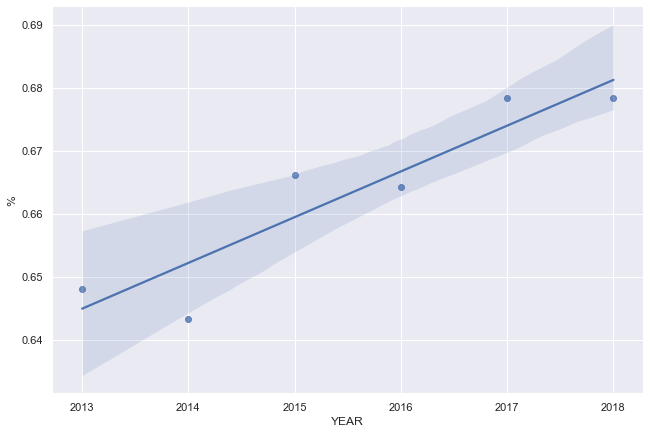

In [12]:
# Plotting % of households that are measured (Bemeten)
g = sns.lmplot(x='YEAR', y='%', data=df_households.loc[2013:2018].reset_index(),\
    palette='plasma', height=6, aspect=1.5)

plt.show()

In [13]:
# Fitting LR through datapoints to get coefficient
X = np.array(df_households.loc[2013:2018].index).reshape(-1, 1)
y = np.array(df_households.loc[2013:2018].reset_index()['%'])
mod = LinearRegression().fit(X, y)
mod.coef_[0]

0.00726317874293558

In [14]:
# Extrapolating trendline
extrap = [y[-1] + mod.coef_[0] * i for i in range(1, 9)]
extrap

[0.6855550670832921,
 0.6928182458262276,
 0.7000814245691632,
 0.7073446033120988,
 0.7146077820550344,
 0.72187096079797,
 0.7291341395409056,
 0.7363973182838411]

In [15]:
df_households = df_households.loc[2013:2018].reset_index().append(pd.DataFrame(zip(range(2019, 2027), extrap))\
    .rename(columns={0: 'YEAR', 1: '%'}))
df_households

,YEAR,HB,Total_HH,%
0,2013,3.046001e+07,47000000.0,0.648085
1,2014,3.087765e+07,48000000.0,0.643284
2,2015,3.204411e+07,48100000.0,0.666198
3,2016,3.267650e+07,49200000.0,0.664157
4,2017,3.303602e+07,48700000.0,0.678358
5,2018,3.388068e+07,49950000.0,0.678292
0,2019,NaN,NaN,0.685555
1,2020,NaN,NaN,0.692818
2,2021,NaN,NaN,0.700081
3,2022,NaN,NaN,0.707345


In [16]:
# Now getting business consumption
df_businesses = df_types.loc['ZB'].to_frame().join(total_businesses)
df_businesses['%'] = df_businesses.ZB / df_businesses.Total_BS
df_businesses

,ZB,Total_BS,%
YEAR,,,
2010,1.672430e+07,NaN,NaN
2011,1.757974e+07,NaN,NaN
2012,1.800160e+07,NaN,NaN
2013,1.799651e+07,18700000.0,0.962380
2014,1.879715e+07,19500000.0,0.963957
2015,1.950007e+07,20000000.0,0.975003
2016,1.923732e+07,20200000.0,0.952343
2017,1.973544e+07,20900000.0,0.944279
2018,2.029208e+07,21200000.0,0.957173


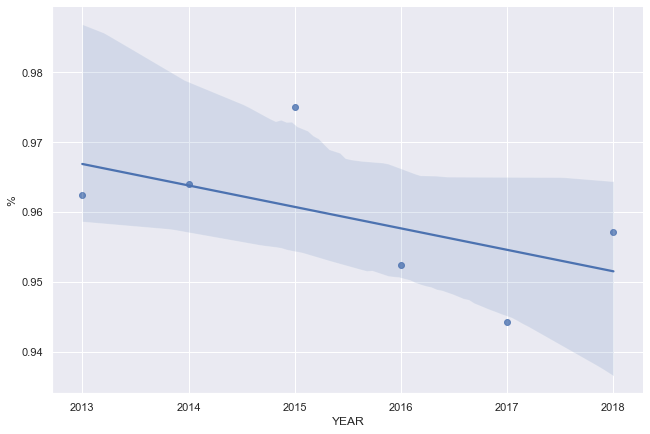

In [17]:
# Plotting % of business that are measured (Bemeten)
g = sns.lmplot(x='YEAR', y='%', data=df_businesses.loc[2013:2018].reset_index(),\
    palette='plasma', height=6, aspect=1.5)

plt.show()

In [18]:
# Fitting LR through datapoints to get coefficient
X = np.array(df_businesses.loc[2013:2018].index).reshape(-1, 1)
y = np.array(df_businesses.loc[2013:2018].reset_index()['%'])
mod = LinearRegression().fit(X, y)
mod.coef_[0]

-0.003077900225942534

In [19]:
# Extrapolating trendline
extrap = [y[-1] + mod.coef_[0] * i for i in range(1, 9)]
extrap

[0.954095589537559,
 0.9510176893116166,
 0.947939789085674,
 0.9448618888597314,
 0.9417839886337889,
 0.9387060884078464,
 0.9356281881819039,
 0.9325502879559613]

In [20]:
df_businesses = df_businesses.loc[2013:2018].reset_index().append(pd.DataFrame(zip(range(2019, 2027), extrap))\
    .rename(columns={0: 'YEAR', 1: '%'}))
df_businesses

,YEAR,ZB,Total_BS,%
0,2013,1.799651e+07,18700000.0,0.962380
1,2014,1.879715e+07,19500000.0,0.963957
2,2015,1.950007e+07,20000000.0,0.975003
3,2016,1.923732e+07,20200000.0,0.952343
4,2017,1.973544e+07,20900000.0,0.944279
5,2018,2.029208e+07,21200000.0,0.957173
0,2019,NaN,NaN,0.954096
1,2020,NaN,NaN,0.951018
2,2021,NaN,NaN,0.947940
3,2022,NaN,NaN,0.944862


In [21]:
# Splitting into Households and Business subsets
df_target_HB = df_target.loc[df_target.OBJECT_CLUSTER.str[:2] == 'HB'].groupby(['REGION', 'YEAR']).sum().reset_index()
df_target_ZB = df_target.loc[df_target.OBJECT_CLUSTER.str[:2] == 'ZB'].groupby(['REGION', 'YEAR']).sum().reset_index()
df_target_HB

,REGION,YEAR,AVG_DAY
0,Amstelveen,2010,3.046941e+06
1,Amstelveen,2011,3.368218e+06
2,Amstelveen,2012,3.495221e+06
3,Amstelveen,2013,3.393728e+06
4,Amstelveen,2014,3.383896e+06
...,...,...,...
115,Zuidoost,2015,4.040973e+06
116,Zuidoost,2016,4.132988e+06
117,Zuidoost,2017,4.067511e+06
118,Zuidoost,2018,4.172240e+06


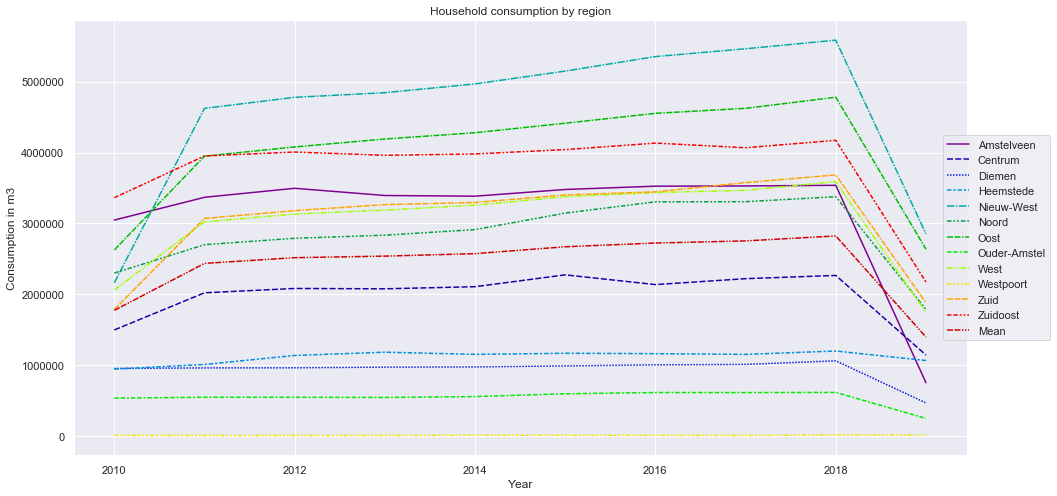

In [22]:
# Plot yearly trend for households
df = pd.pivot_table(df_target_HB, index='YEAR', columns='REGION', values='AVG_DAY', aggfunc=np.sum)
df['Mean'] = df.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df, ax=ax, palette='nipy_spectral')
ax.set(xlabel='Year', ylabel='Consumption in m3', title='Household consumption by region')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

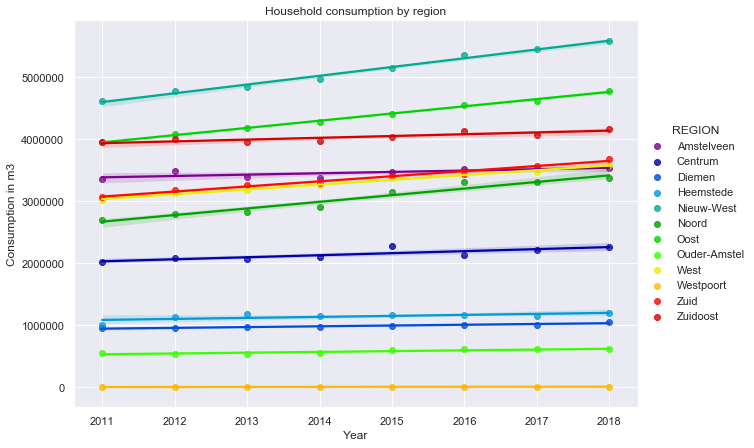

In [23]:
# Yearly lm plot for households
g = sns.lmplot(x='YEAR', y='AVG_DAY', hue='REGION',\
    data=df_target_HB.loc[df_target_HB.YEAR.between(2011, 2018)],\
        palette='nipy_spectral', height=6, aspect=1.5)
g.set(xlabel='Year', ylabel='Consumption in m3', title='Household consumption by region')

plt.show()

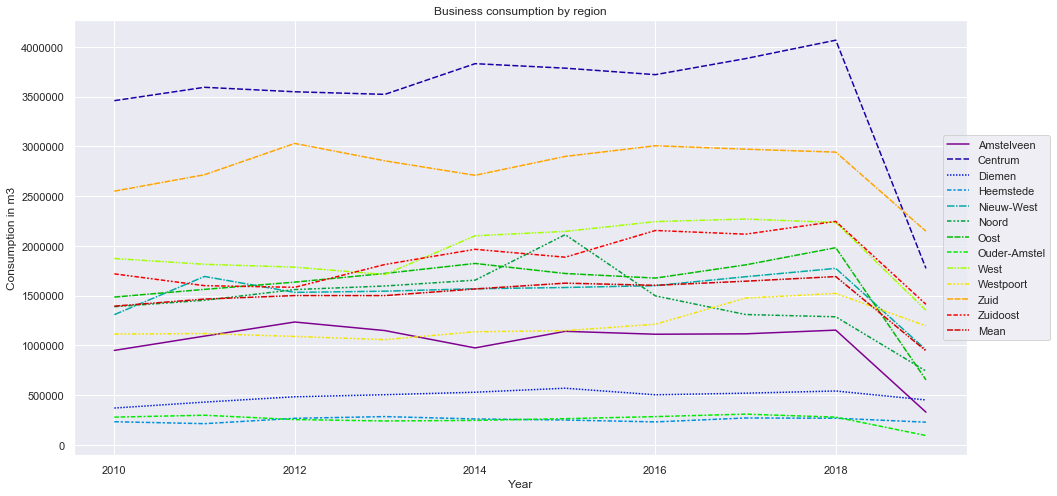

In [24]:
# Plot yearly trend for businesses
df2 = pd.pivot_table(df_target_ZB, index='YEAR', columns='REGION', values='AVG_DAY', aggfunc=np.sum)
df2['Mean'] = df2.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df2, ax=ax, palette='nipy_spectral')
ax.set(xlabel='Year', ylabel='Consumption in m3', title='Business consumption by region')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

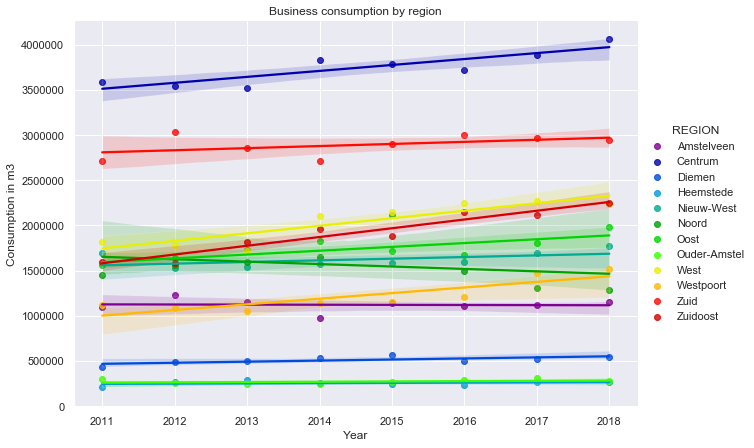

In [25]:
# Yearly lm plot for businesses
g = sns.lmplot(x='YEAR', y='AVG_DAY', hue='REGION',\
    data=df_target_ZB.loc[df_target_ZB.YEAR.between(2011, 2018)],\
        palette='nipy_spectral', height=6, aspect=1.5)
g.set(xlabel='Year', ylabel='Consumption in m3', title='Business consumption by region')

plt.show()

In [385]:
# Loading input dataset
df_input = pd.read_csv('data/scenario_0.csv', sep=',', decimal='.')
# Removing Muiden from data, because of change of municipality in 2015
df_input = df_input.loc[df_input.REGION != 'Muiden']
# Including full dataset, up to 2026
df_input = df_input.loc[df_input.YEAR.between(2011, 2026)]
# Adding time dummies
df_input['time'] = df_input.YEAR#pd.Categorical(df_input.YEAR)
#df_input['entity'] = pd.Categorical(df_input.REGION)
# Adding population multiplier to adjust for more people working from home
df_input.loc[df_input.YEAR == 2020, 'POPULATION'] *= 1.02
df_input.loc[df_input.YEAR == 2020, 'PLACES_TO_EAT'] *= 1.3
# Setting multi-index
df_input = df_input.set_index(['REGION', 'YEAR'])
df_input

POPULATION  POPULATION 0 TO 15 Y/O  \
REGION     YEAR                                         
Amstelveen 2011  81796.000000            13594.000000   
           2012  83363.000000            13927.000000   
           2013  84379.000000            14182.000000   
           2014  85015.000000            14359.000000   
           2015  87162.000000            14857.000000   
...                       ...                     ...   
Zuidoost   2022  91400.300503            14290.343934   
           2023  92278.270199            14170.174535   
           2024  93156.239896            14050.005137   
           2025  94034.209592            13929.835738   
           2026  94912.179289            13809.666339   

                 POPULATION 15 TO 25 Y/O  POPULATION 25 TO 45 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011              9688.000000             21091.000000   
           2012              9850.000000             21508.000000   
           2013             10070.000000             21666.000000   
           2014             10167.000000             21619.000000   
           2015             10560.000000             22158.000000   
...                                  ...                      ...   
Zuidoost   2022             14333.505379             26522.011857   
           2023             14530.559932             26790.353663   
           2024             14727.614485             27058.695469   
           2025             14924.669039             27327.037276   
           2026             15121.723592             27595.379082   

                 POPULATION 45 TO 65 Y/O  POPULATION 65 Y/O AND UP  \
REGION     YEAR                                                      
Amstelveen 2011             22362.000000              15061.000000   
           2012             22440.000000              15638.000000   
           2013             22472.000000              15989.000000   
           2014             22678.000000              16192.000000   
           2015             22993.000000              16594.000000   
...                                  ...                       ...   
Zuidoost   2022             24220.196559              11947.622670   
           2023             24314.952955              12356.458436   
           2024             24409.709350              12765.294202   
           2025             24504.465746              13174.129968   
           2026             24599.222141              13582.965734   

                 TOTAL_HOUSEHOLDS  SINGLE_PERSON_HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011      39669.000000              17441.000000   
           2012      40295.000000              17602.000000   
           2013      40865.000000              17999.000000   
           2014      40942.000000              17779.000000   
           2015      42154.000000              18468.000000   
...                           ...                       ...   
Zuidoost   2022      49372.606113              27895.778667   
           2023      50112.545512              28567.593819   
           2024      50852.484911              29239.408970   
           2025      51592.424311              29911.224121   
           2026      52332.363710              30583.039273   

                 HOUSEHOLDS_WO_CHILDREN  HOUSEHOLDS_W_CHILDREN  \
REGION     YEAR                                                  
Amstelveen 2011             9879.000000           12349.000000   
           2012            10070.000000           12623.000000   
           2013             9990.000000           12876.000000   
           2014            10025.000000           13138.000000   
           2015            10187.000000           13499.000000   
...                                 ...                    ...   
Zuidoost   2022             7388.977177           14172.486970   
           2023             7454.607481           1418

In [717]:
# Splitting into train and test sets
train = df_input.loc(axis=0)[(slice(None), slice(2011,2017))]
test = df_input.loc(axis=0)[(slice(None), 2018)]
fcst = df_input.loc(axis=0)[(slice(None), slice(2011,2018))]
extrap = df_input.loc(axis=0)[(slice(None), slice(2019, 2026))]
print(train.shape, test.shape, extrap.shape)

(84, 30) (12, 30) (96, 30)


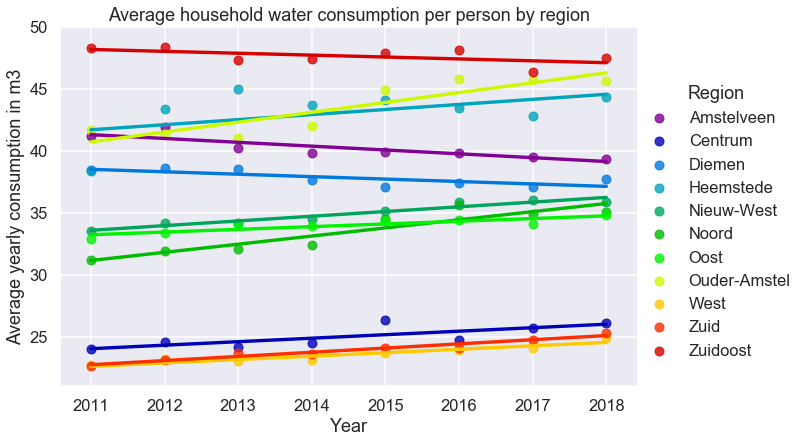

In [718]:
df_consumption = train.append(test).reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION'])\
    [['REGION', 'YEAR', 'POPULATION', 'AVG_DAY']]
# add calculated column with consumption per person
df_consumption['CONSUMPTION_PP'] = df_consumption['AVG_DAY'] / df_consumption['POPULATION']

sns.set_context('talk', rc={'font_scale':1.2})#, 'axes.titlesize':18, 'axes.labelsize':18})

# Plotting consumption per person for each region
g = sns.lmplot(x='YEAR', y='CONSUMPTION_PP', hue='REGION',\
    data=df_consumption.loc[df_consumption.REGION != 'Westpoort'],\
        palette='nipy_spectral', height=6, aspect=1.50, ci=None)

g.set(xlabel='Year', ylabel='Average yearly consumption in m3',\
    title='Average household water consumption per person by region')
g.legend.set_title('Region')

plt.show()

In [719]:
# function to add group-meaned and de-meaned features to dataframe
def bw_est(df):
    for col in df.columns:
        df = df.reset_index().merge(df[col].mean(level=0).rename('{}_between'.format(col)),\
            on='REGION', how='left').set_index(['REGION', 'YEAR'])
        df['{}_within'.format(col)] = df[col] - df['{}_between'.format(col)]
    return df

# function to prepare training and test sets for modelling
def prep_dataset(train, test, y):
    # normalizing numerical features
    scaler = StandardScaler()
    train[train.columns.drop('time')] = scaler.fit_transform(train.drop('time', axis=1))
    test[test.columns.drop('time')] = scaler.transform(test.drop('time', axis=1))

    # creating dict to store datasets
    datasets = {'train': bw_est(train), 'test': bw_est(test)}

    for c in itertools.product(datasets.keys(), ['hb', 'zb']):
        right = y.loc[y.OBJECT_CLUSTER.str[:2] == c[1].upper()].groupby(['REGION', 'YEAR']).sum().reset_index()
        datasets['_'.join(c)] = datasets[c[0]].reset_index().merge(right, how='left', on=['YEAR', 'REGION'])\
        .set_index(['REGION', 'YEAR'])

    return datasets


In [720]:
# Obtaining train and test sets
datasets = prep_dataset(train, test, df_target)
train_HB, train_ZB = datasets['train_hb'], datasets['train_hb']
test_HB, test_ZB = datasets['test_hb'], datasets['test_zb']
train_HB

2015                        -0.001470   
           2016                         0.077691   
           2017                         0.164209   

                 HOUSEHOLDS_WO_CHILDREN_between  \
REGION     YEAR                                   
Amstelveen 2011                        0.182595   
           2012                        0.182595   
           2013                        0.182595   
           2014                        0.182595   
           2015                        0.182595   
...                                         ...   
Zuidoost   2013                       -0.371846   
           2014                       -0.371846   
           2015                       -0.371846   
           2016                       -0.371846   
           2017                       -0.371846   

                 HOUSEHOLDS_WO_CHILDREN_within  HOUSEHOLDS_W_CHILDREN_between  \
REGION     YEAR                                                                 
Amstelveen 2011                      -0.031050                       0.310039   
           2012                       0.002108                       0.310039   
           2013                      -0.011780                       0.310039   
           2014                      -0.005704                       0.310039   
           2015                       0.022419                       0.310039   
...                                        ...                            ...   
Zuidoost   2013                       0.002341                       0.438413   
           2014                      -0.001825                       0.438413   
           2015                       0.007098                       0.438413   
           2016                       0.014910                       0.438413   
           2017                       0.038346                       0.438413   

                 HOUSEHOLDS_W_CHILDREN_within  AIRBNB_REVIEWS_between  \
REGION     YEAR                                                         
Amstelveen 2011                     -0.122816               -0.477539   
           2012                     -0.083092               -0.477539   
           2013                     -0.046413               -0.477539   
           2014                     -0.008429               -0.477539   
           2015                      0.043907               -0.477539   
...                                       ...                     ...   
Zuidoost   2013                      0.014994               -0.399173   
           2014                      0.007817               -0.399173   
           2015                     -0.004585               -0.399173   
           2016                     -0.004585               -0.399173   
           2017                      0.009187               -0.399173   

                 AIRBNB_REVIEWS_within  UNEMPLOYMENT_WW_between  \
REGION     YEAR                                                   
Amstelveen 2011               0.000000                -0.197369   
           2012               0.000000                -0.197369   
           2013               0.000000                -0.197369   
           2014               0.000000                -0.197369   
           2015               0.000000                -0.197369   
...                                ...                      ...   
Zuidoost   2013              -0.077365                 0.631920   
           2014              -0.059333                 0.631920   
           2015              -0.005839                 0.631920   
           2016               0.079912                 0.631920   
           2017               0.218956                 0.631920   

                 UNEMPLOYMENT_WW_within  NUMBER_OF_JOBS_between  \
REGION     YEAR                                                   
Amstelveen 2011               -0.340389               -0.188459   
           2012               -0.094485               -0.188459   
           2013                0.176857       

In [721]:
train_HB.columns

Index(['POPULATION', 'POPULATION 0 TO 15 Y/O', 'POPULATION 15 TO 25 Y/O',
       'POPULATION 25 TO 45 Y/O', 'POPULATION 45 TO 65 Y/O',
       'POPULATION 65 Y/O AND UP', 'TOTAL_HOUSEHOLDS',
       'SINGLE_PERSON_HOUSEHOLDS', 'HOUSEHOLDS_WO_CHILDREN',
       'HOUSEHOLDS_W_CHILDREN', 'AIRBNB_REVIEWS', 'UNEMPLOYMENT_WW',
       'NUMBER_OF_JOBS', 'GUESTS_HOTELS', 'OVERNIGHT_STAYS_HOTELS',
       'BUILT_before_1945', 'BUILT_1945_to_1965', 'BUILT_1965_to_1975',
       'BUILT_1975_to_1985', 'BUILT_1985_to_1995', 'BUILT_1995_to_2005',
       'BUILT_2005_to_2015', 'RENTAL_HOMES', 'UNINHABITED', 'LOW_INCOMES',
       'HIGH_INCOME', 'PLACES_TO_EAT', 'NATURAL_GAS_M3', 'ELECTRICITY_KWH',
       'time', 'POPULATION_between', 'POPULATION_within',
       'POPULATION 0 TO 15 Y/O_between', 'POPULATION 0 TO 15 Y/O_within',
       'POPULATION 15 TO 25 Y/O_between', 'POPULATION 15 TO 25 Y/O_within',
       'POPULATION 25 TO 45 Y/O_between', 'POPULATION 25 TO 45 Y/O_within',
       'POPULATION 45 TO 65 Y/O_

In [722]:
# Defining Time-Varying (TV) variables for households
tv_vars_hb = ['POPULATION', 'TOTAL_HOUSEHOLDS', 'SINGLE_PERSON_HOUSEHOLDS', 'UNEMPLOYMENT_WW', 'AIRBNB_REVIEWS']\
    'OVERNIGHT_STAYS_HOTELS', 'HIGH_INCOME', 'NATURAL_GAS_M3', 'BUILT_1965_to_1975', 'ELECTRICITY_KWH']
# Defining Time-Varying (TV) variables for businesses
tv_vars_zb = ['POPULATION', 'TOTAL_HOUSEHOLDS', 'SINGLE_PERSON_HOUSEHOLDS', 'HOUSEHOLDS_WO_CHILDREN',\
    'AIRBNB_REVIEWS', 'UNEMPLOYMENT_WW', 'NUMBER_OF_JOBS', 'OVERNIGHT_STAYS_HOTELS', 'PLACES_TO_EAT',\
        'NATURAL_GAS_M3', 'ELECTRICITY_KWH']


SyntaxError: invalid syntax (<ipython-input-722-bee0eafadec2>, line 3)

In [691]:
['_'.join(x) for x in itertools.product(tv_vars_hb, ['between', 'within'])]

['POPULATION_between',
 'POPULATION_within',
 'TOTAL_HOUSEHOLDS_between',
 'TOTAL_HOUSEHOLDS_within',
 'SINGLE_PERSON_HOUSEHOLDS_between',
 'SINGLE_PERSON_HOUSEHOLDS_within',
 'UNEMPLOYMENT_WW_between',
 'UNEMPLOYMENT_WW_within']

In [692]:
# Random effects on households:
endo = train_HB.AVG_DAY
#exog_vars = ['SINGLE-PERSON HOUSEHOLDS',#'HOUSEHOLDS W/O CHILDREN',\
#    'AIRBNB_REVIEWS', 'UNEMPLOYMENT_WW', 'NUMBER_OF_JOBS', 'OVERNIGHT_STAYS_HOTELS', 'PLACES_TO_EAT',\
#        'POPULATION_between', 'POPULATION_within', 'TOTAL_HOUSEHOLDS_between', 'TOTAL_HOUSEHOLDS_within']
             #, 'RENTAL_HOMES', 'HIGH_INCOME', 'BUILT_before_1945', 'BUILT_1945_to_1965', 'BUILT_1975_to_1985', 'BUILT_1985_to_1995']
exog_vars = ['_'.join(x) for x in itertools.product(tv_vars_hb, ['between', 'within'])]
exog = sm.add_constant(train_HB[exog_vars])

RE_res_hb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')
RE_res_hb

Dep. Variable:,AVG_DAY,R-squared:,0.8570
Estimator:,RandomEffects,R-squared (Between):,0.9507
No. Observations:,84,R-squared (Within):,0.8430
Date:,"Sat, Jan 30 2021",R-squared (Overall):,0.9497
Time:,01:40:55,Log-likelihood,-1042.1
Cov. Estimator:,Robust,,
,,F-statistic:,56.187
Entities:,12,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(8,75)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,52.950


In [693]:
RE_res_hb.variance_decomposition

Effects                   4.668866e+11
Residual                  4.378956e+09
Percent due to Effects    9.907081e-01
Name: Variance Decomposition, dtype: float64

In [694]:
bet_vars = ['{}_between'.format(var) for var in tv_vars_hb]
wit_vars = ['{}_within'.format(var) for var in tv_vars_hb]

endo = train_HB.AVG_DAY
exog_vars = bet_vars + wit_vars
exog = sm.add_constant(train_HB[exog_vars])

In [695]:
exog_vars

['POPULATION_between',
 'TOTAL_HOUSEHOLDS_between',
 'SINGLE_PERSON_HOUSEHOLDS_between',
 'UNEMPLOYMENT_WW_between',
 'POPULATION_within',
 'TOTAL_HOUSEHOLDS_within',
 'SINGLE_PERSON_HOUSEHOLDS_within',
 'UNEMPLOYMENT_WW_within']

In [696]:
formula = 'AVG_DAY ~ time + ' + ' + '.join(exog_vars)
groups = train_HB.index.get_level_values('REGION').values

mod = smf.mixedlm(formula, train_HB, groups=groups, re_formula='~ ' + ' + '.join(wit_vars))
mdf = mod.fit(method=["lbfgs"])
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                               Mixed Linear Model Regression Results
====================================================================================================================================
Model:                                     MixedLM                        Dependent Variable:                        AVG_DAY        
No. Observations:                          84                             Method:                                    REML           
No. Groups:                                12                             Scale:                                     1711360793.0848
Min. group size:                           7                              Log-Likelihood:                            -927.1848      
Max. group size:                           7                              Converged:                                 Yes            
Mean group size:                           7.0                                                                                      
------------------------------------------------------------------------------------------------------------------------------------
                                                                    Coef.          Std.Err.     z    P>|z|     [0.025       0.975]  
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         -17455982.234   8535980.493 -2.045 0.041 -34186196.573 -725767.895
time                                                                   9958.998      4237.810  2.350 0.019      1653.043   18264.953
POPULATION_between                                                  4234368.167   2746946.576  1.541 0.123  -1149548.189 9618284.524
TOTAL_HOUSEHOLDS_between                                           -4378074.505   4920630.537 -0.890 0.374 -14022333.139 5266184.128
SINGLE_PERSON_HOUSEHOLDS_between                                     463016.183   3020887.072  0.153 0.878  -5457813.679 6383846.045
UNEMPLOYMENT_WW_between                                             1159455.921                                                     
POPULATION_within                                                   1732487.163                                                     
TOTAL_HOUSEHOLDS_within                                              906883.771                                                     
SINGLE_PERSON_HOUSEHOLDS_within                                     -678326.507    851677.464 -0.796 0.426  -2347583.662  990930.648
UNEMPLOYMENT_WW_within                                               -16359.456     26253.947 -0.623 0.533    -67816.247   35097.336
Group Var                                                      210985464739.325                                                     
Group x POPULATION_within Cov                                 -130993916792.161                                                     
POPULATION_within Var                                          157357967494.503  77723851.681                                       
Group x TOTAL_HOUSEHOLDS_within Cov                           -104857053573.720                                                     
POPULATION_within x TOTAL_HOUSEHOLDS_within Cov                119969735240.053 115602024.860                                       
TOTAL_HOUSEHOLDS_within Var                                    117555017991.307 135630484.291                                       
Group x SINGLE_PERSON_HOUSEHOLDS_within Cov                    -85822254630.688                                                     
POPULATION_within x SINGLE_PERSON_HOUSEHOLDS_within Cov         93054893950.674  47411597.516                                       
TOTAL_HOUSEHOLDS_within x SINGLE_PERSON_HOUSEHOLDS_within Cov   85407392161.716  67467751.476                                       
SINGLE_PE

In [697]:
### TESTING
# Testing on household data
exog = sm.add_constant(test_HB[['time'] + exog_vars])
res_hb = mdf.predict(exog=exog)#RE_res_hb.predict(exog, effects=True)

com_hb = res_hb.rename('predictions').reset_index()\
    .merge(test_HB.AVG_DAY, how='left', on=['REGION', 'YEAR']).set_index(['REGION', 'YEAR'])
com_hb['error'] = com_hb.AVG_DAY - com_hb.predictions
com_hb['rel_error'] = com_hb.error / com_hb.AVG_DAY
com_hb

,,predictions,AVG_DAY,error,rel_error
REGION,YEAR,,,,
Amstelveen,2018,2.878703e+06,3.537490e+06,658787.072265,0.186230
Centrum,2018,1.468409e+06,2.265953e+06,797544.347748,0.351969
Diemen,2018,9.796680e+05,1.061387e+06,81719.020693,0.076993
Heemstede,2018,1.040209e+06,1.199399e+06,159190.405292,0.132725
Nieuw-West,2018,5.533445e+06,5.584929e+06,51483.323862,0.009218
Noord,2018,3.444919e+06,3.376329e+06,-68589.645965,-0.020315
Oost,2018,4.241568e+06,4.780079e+06,538511.519183,0.112657
Ouder-Amstel,2018,7.017676e+05,6.155463e+05,-86221.250629,-0.140073
West,2018,3.871894e+06,3.588555e+06,-283339.010089,-0.078956


In [698]:
total_consumption = com_hb.AVG_DAY.sum()
total_predicted = com_hb.predictions.sum()
rmse = np.sqrt(np.average(com_hb.error ** 2))
total_error = com_hb.error.sum()
total_rel_error = total_error / total_consumption
print('Total consumption: {:,.0f} m3'.format(total_consumption))
print('Total prediction: {:,.0f} m3'.format(total_predicted))
print('RMSE: {:,.0f} m3'.format(rmse))
print('Total error: {:,.0f} m3'.format(total_error))
print('Total relative error: {:.2%}'.format(total_rel_error))

Total consumption: 33,880,680 m3
Total prediction: 30,611,402 m3
RMSE: 484,174 m3
Total error: 3,269,278 m3
Total relative error: 9.65%


In [699]:
# Obtaining forecasting sets
datasets = prep_dataset(fcst, extrap, df_target)
fcst_HB, fcst_ZB = datasets['train_hb'], datasets['train_hb']
extrap_HB, extrap_ZB = datasets['test_hb'], datasets['test_zb']
fcst_HB

2016                         0.055165   
           2017                         0.141430   
           2018                         0.156101   

                 HOUSEHOLDS_WO_CHILDREN_between  \
REGION     YEAR                                   
Amstelveen 2011                        0.168970   
           2012                        0.168970   
           2013                        0.168970   
           2014                        0.168970   
           2015                        0.168970   
...                                         ...   
Zuidoost   2014                       -0.373773   
           2015                       -0.373773   
           2016                       -0.373773   
           2017                       -0.373773   
           2018                       -0.373773   

                 HOUSEHOLDS_WO_CHILDREN_within  HOUSEHOLDS_W_CHILDREN_between  \
REGION     YEAR                                                                 
Amstelveen 2011                      -0.030699                       0.318857   
           2012                       0.002081                       0.318857   
           2013                      -0.011649                       0.318857   
           2014                      -0.005642                       0.318857   
           2015                       0.022161                       0.318857   
...                                        ...                            ...   
Zuidoost   2014                      -0.007187                       0.427709   
           2015                       0.001635                       0.427709   
           2016                       0.009358                       0.427709   
           2017                       0.032527                       0.427709   
           2018                       0.037676                       0.427709   

                 HOUSEHOLDS_W_CHILDREN_within  AIRBNB_REVIEWS_between  \
REGION     YEAR                                                         
Amstelveen 2011                     -0.141459               -0.499058   
           2012                     -0.101984               -0.499058   
           2013                     -0.065534               -0.499058   
           2014                     -0.027787               -0.499058   
           2015                      0.024222               -0.499058   
...                                       ...                     ...   
Zuidoost   2014                      0.007077               -0.397491   
           2015                     -0.005248               -0.397491   
           2016                     -0.005248               -0.397491   
           2017                      0.008439               -0.397491   
           2018                      0.004837               -0.397491   

                 AIRBNB_REVIEWS_within  UNEMPLOYMENT_WW_between  \
REGION     YEAR                                                   
Amstelveen 2011               0.000000                -0.211332   
           2012               0.000000                -0.211332   
           2013               0.000000                -0.211332   
           2014               0.000000                -0.211332   
           2015               0.000000                -0.211332   
...                                ...                      ...   
Zuidoost   2014              -0.086452                 0.619236   
           2015              -0.043972                 0.619236   
           2016               0.024124                 0.619236   
           2017               0.134541                 0.619236   
           2018               0.275346                 0.619236   

                 UNEMPLOYMENT_WW_within  NUMBER_OF_JOBS_between  \
REGION     YEAR                                                   
Amstelveen 2011               -0.317639               -0.195359   
           2012               -0.069517               -0.195359   
           2013                0.204273       

In [700]:
### FORECASTING
# Retraining model on forecasting set
endo = fcst_HB.AVG_DAY
exog = sm.add_constant(fcst_HB[exog_vars])
RE_res_hb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')

# Forecasting on household data
exog = sm.add_constant(extrap_HB[exog_vars])
res_hb = RE_res_hb.predict(exog, effects=True)
res_hb

predictions
REGION     YEAR              
Amstelveen 2019  2.720383e+06
           2020  2.879263e+06
           2021  2.862527e+06
           2022  2.922150e+06
           2023  2.981774e+06
...                       ...
Zuidoost   2022  2.607715e+06
           2023  2.645850e+06
           2024  2.683984e+06
           2025  2.722119e+06
           2026  2.760254e+06

[96 rows x 1 columns]

In [701]:
# Total predictions for households 2021-2026
pred_hb = res_hb.sum(level=1)
pred_hb

,predictions
YEAR,
2019,2.784818e+07
2020,2.971158e+07
2021,2.906606e+07
2022,2.967582e+07
2023,3.028558e+07
2024,3.089533e+07
2025,3.150509e+07
2026,3.211485e+07


In [702]:
df_hb_res = df_households.set_index('YEAR').join(pred_hb)
df_hb_res['Total_pred_HH'] = df_hb_res['predictions'] / df_hb_res['%']
df_hb_res = df_hb_res.join(total_households_forecast)
df_hb_res

,HB,Total_HH,%,predictions,Total_pred_HH,Forecast_HH
YEAR,,,,,,
2013,3.046001e+07,47000000.0,0.648085,NaN,NaN,NaN
2014,3.087765e+07,48000000.0,0.643284,NaN,NaN,NaN
2015,3.204411e+07,48100000.0,0.666198,NaN,NaN,NaN
2016,3.267650e+07,49200000.0,0.664157,NaN,NaN,NaN
2017,3.303602e+07,48700000.0,0.678358,NaN,NaN,49890000.0
2018,3.388068e+07,49950000.0,0.678292,NaN,NaN,50280000.0
2019,NaN,NaN,0.685555,2.784818e+07,4.062136e+07,50190000.0
2020,NaN,NaN,0.692818,2.971158e+07,4.288511e+07,51050000.0
2021,NaN,NaN,0.700081,2.906606e+07,4.151811e+07,51440000.0


In [703]:
# Random effects on businesses
endo = train_ZB.AVG_DAY
exog_vars = ['{}_between'.format(var) for var in tv_vars_zb] + ['{}_within'.format(var) for var in tv_vars_zb]# + ['year']
exog = sm.add_constant(train_ZB[exog_vars])

RE_res_zb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')
RE_res_zb

Dep. Variable:,AVG_DAY,R-squared:,0.9989
Estimator:,RandomEffects,R-squared (Between):,1.0000
No. Observations:,84,R-squared (Within):,0.8756
Date:,"Sat, Jan 30 2021",R-squared (Overall):,0.9989
Time:,01:41:00,Log-likelihood,-1030.4
Cov. Estimator:,Robust,,
,,F-statistic:,2503.8
Entities:,12,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(22,61)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,1.055e+04


In [704]:
### TESTING
# Testing on business data
exog = sm.add_constant(test_ZB[exog_vars])
res_zb = RE_res_zb.predict(exog, effects=True)

com_zb = res_zb.reset_index().merge(test_ZB.AVG_DAY, how='left', on=['REGION', 'YEAR']).set_index(['REGION', 'YEAR'])
com_zb['error'] = com_zb.AVG_DAY - com_zb.predictions
com_zb['rel_error'] = com_zb.error / com_zb.AVG_DAY
com_zb

,,predictions,AVG_DAY,error,rel_error
REGION,YEAR,,,,
Amstelveen,2018,5.039209e+06,1.152812e+06,-3.886396e+06,-3.371231
Centrum,2018,9.095543e+07,4.066743e+06,-8.688868e+07,-21.365669
Diemen,2018,7.120337e+05,5.410192e+05,-1.710144e+05,-0.316097
Heemstede,2018,1.042966e+06,2.675071e+05,-7.754584e+05,-2.898832
Nieuw-West,2018,1.220066e+07,1.773514e+06,-1.042714e+07,-5.879368
Noord,2018,2.843629e+07,1.286837e+06,-2.714945e+07,-21.097812
Oost,2018,4.629035e+07,1.981231e+06,-4.430912e+07,-22.364439
Ouder-Amstel,2018,3.480562e+06,2.783813e+05,-3.202181e+06,-11.502862
West,2018,9.375090e+07,2.234735e+06,-9.151616e+07,-40.951688


In [705]:
total_consumption = com_zb.AVG_DAY.sum()
total_predicted = com_zb.predictions.sum()
rmse = np.sqrt(np.average(com_zb.error ** 2))
total_error = com_zb.error.sum()
total_rel_error = total_error / total_consumption
print('Total consumption: {:,.0f} m3'.format(total_consumption))
print('Total prediction: {:,.0f} m3'.format(total_predicted))
print('RMSE: {:,.0f} m3'.format(rmse))
print('Total error: {:,.0f} m3'.format(total_error))
print('Total relative error: {:.2%}'.format(total_rel_error))

Total consumption: 20,292,078 m3
Total prediction: 367,188,490 m3
RMSE: 44,526,820 m3
Total error: -346,896,412 m3
Total relative error: -1709.52%


In [706]:
### FORECASTING
# Retraining model on forecasting set
endo = fcst_ZB.AVG_DAY
exog = sm.add_constant(fcst_ZB[exog_vars])
RE_res_zb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')

# Forecasting on business data
exog = sm.add_constant(extrap_ZB[exog_vars])
res_zb = RE_res_zb.predict(exog, effects=True)
res_zb

predictions
REGION     YEAR              
Amstelveen 2019  2.056223e+08
           2020  2.057663e+08
           2021  2.057574e+08
           2022  2.058073e+08
           2023  2.058572e+08
...                       ...
Zuidoost   2022  3.025843e+08
           2023  3.026096e+08
           2024  3.026349e+08
           2025  3.026603e+08
           2026  3.026856e+08

[96 rows x 1 columns]

In [707]:
res_zb.loc(axis=0)[(slice(None), slice(2018,2020))]

predictions
REGION       YEAR              
Amstelveen   2019  2.056223e+08
             2020  2.057663e+08
Centrum      2019 -4.384342e+08
             2020 -4.380954e+08
Diemen       2019  1.085826e+08
             2020  1.086550e+08
Heemstede    2019  6.196517e+07
             2020  6.199400e+07
Nieuw-West   2019  1.825227e+08
             2020  1.827949e+08
Noord        2019 -1.355360e+07
             2020 -1.345752e+07
Oost         2019 -3.361423e+08
             2020 -3.360900e+08
Ouder-Amstel 2019 -8.803081e+07
             2020 -8.801859e+07
West         2019 -7.814152e+08
             2020 -7.814456e+08
Westpoort    2019  4.975076e+07
             2020  4.978083e+07
Zuid         2019 -6.277072e+08
             2020 -6.276272e+08
Zuidoost     2019  3.024926e+08
             2020  3.026709e+08

In [708]:
extrap_ZB.loc(axis=0)[(slice(None), slice(2018,2020))]

-0.449373   
Heemstede    2019               7.404602e-04                   -1.067380   
             2020               1.163580e-03                   -1.067380   
Nieuw-West   2019              -1.443897e-02                    1.790013   
             2020              -1.031355e-02                    1.790013   
Noord        2019               4.442813e-03                    0.200419   
             2020               3.173434e-03                    0.200419   
Oost         2019              -1.906685e-02                    1.979445   
             2020              -1.092179e-02                    1.979445   
Ouder-Amstel 2019              -1.073667e-02                   -1.381602   
             2020              -1.687191e-02                   -1.381602   
West         2019              -3.702301e-04                    0.614791   
             2020              -5.817902e-04                    0.614791   
Westpoort    2019              -2.220446e-16                   -1.555933   
             2020              -2.220446e-16                   -1.555933   
Zuid         2019              -6.330935e-02                   -0.372711   
             2020              -3.506607e-02                   -0.372711   
Zuidoost     2019              -9.181710e-02                    0.186173   
             2020              -6.526634e-02                    0.186173   

                   BUILT_1985_to_1995_within  BUILT_1995_to_2005_between  \
REGION       YEAR                                                          
Amstelveen   2019              -1.832715e-01                   -0.032904   
             2020              -9.959289e-02                   -0.032904   
Centrum      2019              -2.225013e-01                   -0.068811   
             2020              -1.360847e-01                   -0.068811   
Diemen       2019               5.989149e-04                   -0.713344   
             2020              -5.989265e-04                   -0.713344   
Heemstede    2019              -5.989266e-03                   -0.806669   
             2020              -3.251316e-03                   -0.806669   
Nieuw-West   2019              -4.671628e-02                    2.117954   
             2020              -3.336877e-02                    2.117954   
Noord        2019              -7.486583e-03                   -0.406480   
             2020              -7.144339e-03                   -0.406480   
Oost         2019              -2.275921e-01                    2.352690   
             2020              -1.599988e-01                    2.352690   
Ouder-Amstel 2019              -1.497317e-03                   -0.702272   
             2020              -8.128290e-04                   -0.702272   
West         2019              -1.206838e-01                    0.202345   
             2020              -7.157177e-02                    0.202345   
Westpoort    2019              -2.220446e-16                   -0.948040   
             2020              -2.220446e-16                   -0.948040   
Zuid         2019              -7.606367e-02                   -0.281085   
             2020              -5.792475e-02                   -0.281085   
Zuidoost     2019              -1.377531e-02                    0.224886   
             2020              -9.326143e-03                    0.224886   

                   BUILT_1995_to_2005_within  BUILT_2005_to_2015_between  \
REGION       YEAR                                                          
Amstelveen   2019              -1.134924e-02                    0.183322   
             2020              -7.869334e-03                    0.183322   
Centrum      2019              -2.131442e-02                   -0.615345   
             2020              -7.869332e-03                   -0.615345   
Diemen       2019               3.441691e-15                   -0.695549   
             2020               2.442491e-15                   -0.695549   
Heemstede    2019               3

In [709]:
# Total predictions for businesses 2021-2026
pred_zb = res_zb.sum(level=1)
pred_zb

,predictions
YEAR,
2019,-1.374347e+09
2020,-1.373072e+09
2021,-1.373666e+09
2022,-1.373205e+09
2023,-1.372744e+09
2024,-1.372284e+09
2025,-1.371823e+09
2026,-1.371362e+09


In [710]:
df_zb_res = df_businesses.set_index('YEAR').join(pred_zb)
df_zb_res['Total_pred_BS'] = df_zb_res['predictions'] / df_zb_res['%']
df_zb_res = df_zb_res.join(total_businesses_forecast)
df_zb_res

,ZB,Total_BS,%,predictions,Total_pred_BS,Forecast_BS
YEAR,,,,,,
2013,1.799651e+07,18700000.0,0.962380,NaN,NaN,NaN
2014,1.879715e+07,19500000.0,0.963957,NaN,NaN,NaN
2015,1.950007e+07,20000000.0,0.975003,NaN,NaN,NaN
2016,1.923732e+07,20200000.0,0.952343,NaN,NaN,NaN
2017,1.973544e+07,20900000.0,0.944279,NaN,NaN,20500000.0
2018,2.029208e+07,21200000.0,0.957173,NaN,NaN,20600000.0
2019,NaN,NaN,0.954096,-1.374347e+09,-1.440471e+09,21050000.0
2020,NaN,NaN,0.951018,-1.373072e+09,-1.443793e+09,21500000.0
2021,NaN,NaN,0.947940,-1.373666e+09,-1.449107e+09,21460000.0


In [711]:
# Total predictions
pred_hb + pred_zb

,predictions
YEAR,
2019,-1.346499e+09
2020,-1.343361e+09
2021,-1.344600e+09
2022,-1.343529e+09
2023,-1.342459e+09
2024,-1.341388e+09
2025,-1.340318e+09
2026,-1.339247e+09


In [712]:
df_predicted = df_hb_res[['Total_HH', 'Forecast_HH', 'Total_pred_HH']]\
    .join(df_zb_res[['Total_BS', 'Forecast_BS', 'Total_pred_BS']])
df_predicted['Total consumption'] = df_predicted.Total_HH + df_predicted.Total_BS
df_predicted['Total prediction'] = df_predicted.Total_pred_HH + df_predicted.Total_pred_BS
df_predicted

,Total_HH,Forecast_HH,Total_pred_HH,Total_BS,Forecast_BS,Total_pred_BS,Total consumption,Total prediction
YEAR,,,,,,,,
2013,47000000.0,NaN,NaN,18700000.0,NaN,NaN,65700000.0,NaN
2014,48000000.0,NaN,NaN,19500000.0,NaN,NaN,67500000.0,NaN
2015,48100000.0,NaN,NaN,20000000.0,NaN,NaN,68100000.0,NaN
2016,49200000.0,NaN,NaN,20200000.0,NaN,NaN,69400000.0,NaN
2017,48700000.0,49890000.0,NaN,20900000.0,20500000.0,NaN,69600000.0,NaN
2018,49950000.0,50280000.0,NaN,21200000.0,20600000.0,NaN,71150000.0,NaN
2019,NaN,50190000.0,4.062136e+07,NaN,21050000.0,-1.440471e+09,NaN,-1.399850e+09
2020,NaN,51050000.0,4.288511e+07,NaN,21500000.0,-1.443793e+09,NaN,-1.400908e+09
2021,NaN,51440000.0,4.151811e+07,NaN,21460000.0,-1.449107e+09,NaN,-1.407589e+09


In [713]:
# adding new values
df_predicted.loc[2019, 'Total_HH'] = 50.3e6
#df_predicted.loc[2020, 'Total_HH'] = 70289640 * .69
df_predicted.loc[2019, 'Total_BS'] = 21.3e6
#df_predicted.loc[2020, 'Total_BS'] = 70289640 * .29
df_predicted['Total consumption'] = df_predicted.Total_HH + df_predicted.Total_BS
# changing column names
df_predicted.rename(columns={'Total_HH': 'Actual (H)', 'Forecast_HH': 'Waternet forecast (H)',\
    'Total_pred_HH': 'Scenario 0 (H)', 'Total_BS': 'Actual (B)', 'Forecast_BS': 'Waternet forecast (B)',\
        'Total_pred_BS': 'Scenario 0 (B)', 'Total prediction': 'Scenario 1 total'}, inplace=True)
df_predicted

,Actual (H),Waternet forecast (H),Scenario 0 (H),Actual (B),Waternet forecast (B),Scenario 0 (B),Total consumption,Scenario 1 total
YEAR,,,,,,,,
2013,47000000.0,NaN,NaN,18700000.0,NaN,NaN,65700000.0,NaN
2014,48000000.0,NaN,NaN,19500000.0,NaN,NaN,67500000.0,NaN
2015,48100000.0,NaN,NaN,20000000.0,NaN,NaN,68100000.0,NaN
2016,49200000.0,NaN,NaN,20200000.0,NaN,NaN,69400000.0,NaN
2017,48700000.0,49890000.0,NaN,20900000.0,20500000.0,NaN,69600000.0,NaN
2018,49950000.0,50280000.0,NaN,21200000.0,20600000.0,NaN,71150000.0,NaN
2019,50300000.0,50190000.0,4.062136e+07,21300000.0,21050000.0,-1.440471e+09,71600000.0,-1.399850e+09
2020,NaN,51050000.0,4.288511e+07,NaN,21500000.0,-1.443793e+09,NaN,-1.400908e+09
2021,NaN,51440000.0,4.151811e+07,NaN,21460000.0,-1.449107e+09,NaN,-1.407589e+09


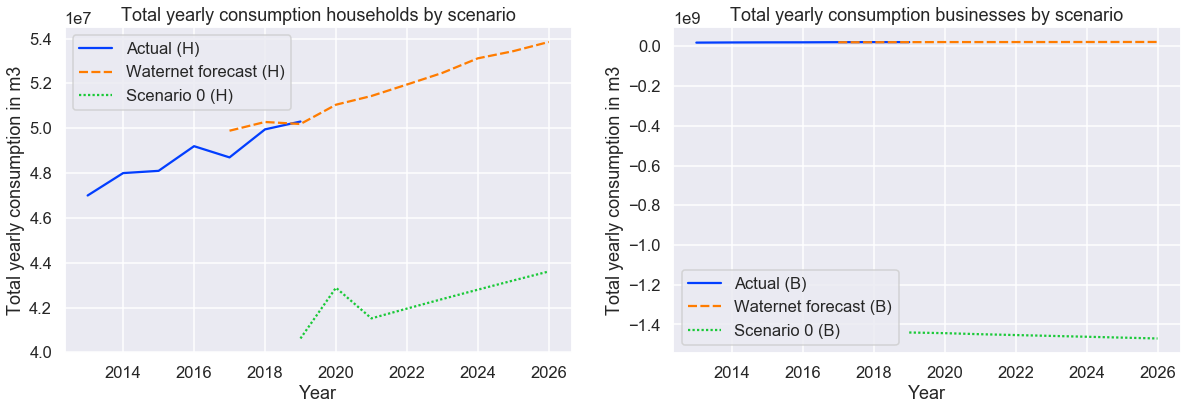

In [714]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(data=df_predicted[['Actual (H)', 'Waternet forecast (H)', 'Scenario 0 (H)']], ax=ax[0], palette='bright')
ax[0].set(xlabel='Year', ylabel='Total yearly consumption in m3',\
    title='Total yearly consumption households by scenario')

sns.lineplot(data=df_predicted[['Actual (B)', 'Waternet forecast (B)', 'Scenario 0 (B)']], ax=ax[1], palette='bright')
ax[1].set(xlabel='Year', ylabel='Total yearly consumption in m3',\
    title='Total yearly consumption businesses by scenario')

# Put a legend to the right side
#plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

In [715]:
# Adding different scenario's:
scen_1 = pd.read_csv('data/scenario_1.csv')
scen_1 = scen_1.loc[scen_1.REGION != 'Muiden'].fillna(0)
# Adding population multiplier to adjust for more people working from home
scen_1.loc[scen_1.YEAR == 2020, 'POPULATION'] *= 1.02
scen_1.loc[scen_1.YEAR.between(2020,2022), 'PLACES_TO_EAT'] *= 1.3
scen_1['POPULATION'] *= 1.157
scen_1['PLACES_TO_EAT'] *= 1.39
# Subsetting prediction years and setting indices
scen_1 = scen_1.loc[scen_1.YEAR >= 2019].set_index(['REGION', 'YEAR'])

# Same for scenario 2
scen_2 = pd.read_csv('data/scenario_2.csv')
scen_2 = scen_2.loc[scen_2.REGION != 'Muiden'].fillna(0)
scen_2.loc[scen_2.YEAR == 2020, 'POPULATION'] *= 1.02
scen_2.loc[scen_2.YEAR.between(2020,2022), 'PLACES_TO_EAT'] *= 1.3
scen_2['POPULATION'] *= 1.157
scen_2['PLACES_TO_EAT'] *= 1.39
scen_2 = scen_2.loc[scen_2.YEAR >= 2019].set_index(['REGION', 'YEAR'])

# normalize column values
scen_1[scen_1.columns] = fcst_scaler.transform(scen_1)
scen_2[scen_2.columns] = fcst_scaler.transform(scen_2)
print(scen_1.shape)
scen_1

(96, 29)


POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2019    0.480479                0.394736                 0.046964   
Centrum    2019    0.388397               -0.620972                -0.056227   
Diemen     2019   -0.926943               -1.005741                -0.848259   
Heemstede  2019   -0.970552               -0.954268                -1.163367   
Nieuw-West 2019    2.010739                1.829164                 1.917122   
...                     ...                     ...                      ...   
Zuidoost   2022    0.493318                0.197405                 0.597095   
           2023    0.513364                0.182782                 0.626565   
           2024    0.533410                0.168159                 0.656035   
           2025    0.553456                0.153536                 0.685505   
           2026    0.573502                0.138913                 0.714975   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2019                -0.167095                 0.257131   
Centrum    2019                 0.282285                 0.291332   
Diemen     2019                -0.934547                -1.109383   
Heemstede  2019                -1.102360                -1.070638   
Nieuw-West 2019                 1.224582                 1.370091   
...                                  ...                      ...   
Zuidoost   2022                -0.022820                 0.341066   
           2023                -0.009438                 0.349188   
           2024                 0.003945                 0.357310   
           2025                 0.017327                 0.365433   
           2026                 0.030709                 0.373555   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2019                  1.117999          0.003661   
Centrum    2019                  0.424484          0.440044   
Diemen     2019                 -0.958171         -0.999647   
Heemstede  2019                 -0.522881         -1.091935   
Nieuw-West 2019                  1.435353          1.151718   
...                                   ...               ...   
Zuidoost   2022                  0.234561          0.215277   
           2023                  0.300792          0.241173   
           2024                  0.367022          0.267069   
           2025                  0.433253          0.292965   
           2026                  0.499484          0.318861   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2019                 -0.253064                 0.195936   
Centrum    2019                  0.744332                 0.550339   
Diemen     2019                 -0.950643                -0.976769   
Heemstede  2019                 -1.097647                -0.964756   
Nieuw-West 2019                  0.834119                 1.043758   
...                                   ...                      ...   
Zuidoost   2022                  0.283414                -0.289077   
           2023                  0.322839                -0.277813   
           2024                  0.362264                -0.266549   
           2025                  0.401688                -0.255285   
           2026                  0.441113                -0.244022   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2019                0.466691       -0.499058        -0.614530   
Centrum    2019               -0.489502        5.213496        -0.229513   
Diemen     2019               -0.966518    

In [716]:
# Joining test set with consumption per object type
scen_1_HB = scen_1.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
scen_2_HB = scen_2.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
# Adding group-meaned and de-meaned variables for TV vars for households
for var in tv_vars_hb:
    scen_1_HB = scen_1_HB.reset_index().merge(fcst_HB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    scen_1_HB['{}_within'.format(var)] = scen_1_HB[var] - scen_1_HB['{}_between'.format(var)]

    scen_2_HB = scen_2_HB.reset_index().merge(fcst_HB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    scen_2_HB['{}_within'.format(var)] = scen_2_HB[var] - scen_2_HB['{}_between'.format(var)]

scen_1_HB.head(10)

KeyError: 'TOTAL_HOUSEHOLDS'

In [235]:
# Forecasting on household data
exog_vars = ['{}_between'.format(var) for var in tv_vars_hb] + ['{}_within'.format(var) for var in tv_vars_hb]
exog = sm.add_constant(scen_1_HB[exog_vars])
res_scen_1_hb = RE_res_hb.predict(exog, effects=True)
pred_scen_1_hb = res_scen_1_hb.sum(level=1).rename(columns={'predictions': 'Scenario 1 (H)'})

exog = sm.add_constant(scen_2_HB[exog_vars])
res_scen_2_hb = RE_res_hb.predict(exog, effects=True)
pred_scen_2_hb = res_scen_2_hb.sum(level=1).rename(columns={'predictions': 'Scenario 2 (H)'})

pred_scen_1_hb

,Scenario 1 (H)
YEAR,
2019,5.040744e+07
2020,5.304670e+07
2021,5.180463e+07
2022,5.261312e+07
2023,5.334523e+07
2024,5.414579e+07
2025,5.495201e+07
2026,5.575822e+07


In [236]:
# Joining test set with consumption per object type
scen_1_ZB = scen_1.reset_index().merge(df_target_ZB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
scen_2_ZB = scen_2.reset_index().merge(df_target_ZB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
# Adding group-meaned and de-meaned variables for TV vars for households
for var in tv_vars_zb:
    scen_1_ZB = scen_1_ZB.reset_index().merge(fcst_ZB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    scen_1_ZB['{}_within'.format(var)] = scen_1_ZB[var] - scen_1_ZB['{}_between'.format(var)]

    scen_2_ZB = scen_2_ZB.reset_index().merge(fcst_ZB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    scen_2_ZB['{}_within'.format(var)] = scen_2_ZB[var] - scen_2_ZB['{}_between'.format(var)]

scen_1_ZB.head()

,,POPULATION,POPULATION 0 TO 15 Y/O,POPULATION 15 TO 25 Y/O,POPULATION 25 TO 45 Y/O,POPULATION 45 TO 65 Y/O,POPULATION 65 Y/O AND UP,TOTAL HOUSEHOLDS,SINGLE-PERSON HOUSEHOLDS,HOUSEHOLDS W/O CHILDREN,HOUSEHOLDS /W CHILDREN,AIRBNB_REVIEWS,UNEMPLOYMENT_WW,NUMBER_OF_JOBS,GUESTS_HOTELS,OVERNIGHT_STAYS_HOTELS,BUILT_before_1945,BUILT_1945_to_1965,BUILT_1965_to_1975,BUILT_1975_to_1985,BUILT_1985_to_1995,BUILT_1995_to_2005,BUILT_2005_to_2015,RENTAL_HOMES,UNINHABITED,LOW_INCOMES,HIGH_INCOME,PLACES_TO_EAT,NATURAL_GAS_M3,ELECTRICITY_KWH,AVG_DAY,POPULATION_between,POPULATION_within,TOTAL HOUSEHOLDS_between,TOTAL HOUSEHOLDS_within,SINGLE-PERSON HOUSEHOLDS_between,SINGLE-PERSON HOUSEHOLDS_within,HOUSEHOLDS W/O CHILDREN_between,HOUSEHOLDS W/O CHILDREN_within,AIRBNB_REVIEWS_between,AIRBNB_REVIEWS_within,UNEMPLOYMENT_WW_between,UNEMPLOYMENT_WW_within,NUMBER_OF_JOBS_between,NUMBER_OF_JOBS_within,OVERNIGHT_STAYS_HOTELS_between,OVERNIGHT_STAYS_HOTELS_within,PLACES_TO_EAT_between,PLACES_TO_EAT_within,NATURAL_GAS_M3_between,NATURAL_GAS_M3_within,ELECTRICITY_KWH_between,ELECTRICITY_KWH_within
REGION,YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amstelveen,2019,0.480479,0.394736,0.046964,-0.167095,0.257131,1.117999,0.003661,-0.253064,0.195936,0.466691,-0.499058,-0.614530,-0.098441,-0.600677,-0.595878,-0.620689,0.525884,1.441230,-0.154047,0.901377,-0.044253,0.128020,-0.328497,0.104151,-0.283329,0.814183,-0.581147,0.963463,1.128511,3.284193e+05,0.107223,0.373257,-0.059448,0.063109,-0.289448,0.036384,0.168970,0.026966,-0.499058,5.551115e-17,-0.211332,-0.403198,-0.195359,0.096918,-0.600305,0.004427,-0.620677,0.039530,1.211157,-0.247694,1.325226,-0.196715
Centrum,2019,0.388397,-0.620972,-0.056227,0.282285,0.291332,0.424484,0.440044,0.744332,0.550339,-0.489502,5.213496,-0.229513,1.784846,4.280986,4.529946,0.719088,-0.633171,-0.934383,-0.036631,0.617315,-0.090125,-0.632755,0.287270,1.910765,-0.114990,-0.006016,3.244498,-0.710054,-0.734073,1.773225e+06,0.100005,0.288392,0.435101,0.004943,0.781448,-0.037116,0.411414,0.138925,1.232329,3.981167e+00,0.126735,-0.356248,1.576629,0.208217,2.925841,1.604105,2.540246,0.704252,-0.711906,0.001851,-0.736069,0.001996
Diemen,2019,-0.926943,-1.005741,-0.848259,-0.934547,-1.109383,-0.958171,-0.999647,-0.950643,-0.976769,-0.966518,-0.499058,-1.127886,-0.815637,-0.632714,-0.629518,-0.762532,-0.506498,-0.602335,-0.104330,-0.448774,-0.713344,-0.695958,-1.016243,-0.954980,-1.031289,-0.886098,-0.657093,0.415717,1.016102,4.510008e+05,-1.075550,0.148607,-1.056474,0.056827,-1.000319,0.049676,-1.044110,0.067341,-0.499058,5.551115e-17,-1.031632,-0.096254,-0.835425,0.019788,-0.637156,0.007638,-0.679848,0.022755,0.919160,-0.503443,1.369253,-0.353151
Heemstede,2019,-0.970552,-0.954268,-1.163367,-1.102360,-1.070638,-0.522881,-1.091935,-1.097647,-0.964756,-0.995620,-0.499058,-1.230557,-1.322844,-0.641969,-0.639235,-0.557724,-0.468496,-0.575413,-0.732663,-1.073369,-0.806669,-0.715855,-1.174362,-0.978412,-1.145832,-0.543531,-0.600217,1.575650,1.285883,2.279211e+05,-1.069412,0.098860,-1.103651,0.011715,-1.109053,0.011407,-0.951412,-0.013344,-0.499058,5.551115e-17,-1.136442,-0.094115,-1.330920,0.008077,-0.639235,0.000000,-0.633159,0.032942,1.917992,-0.342341,1.461990,-0.176107
Nieuw-West,2019,2.010739,1.829164,1.917122,1.224582,1.370091,1.435353,1.151718,0.834119,1.043758,1.826423,0.200195,0.685972,1.067553,0.063163,0.101165,-0.767987,2.804725,0.189963,-0.597265,1.743297,2.064253,1.468155,0.989960,0.291608,1.334317,0.559611,-0.402061,-0.576593,-0.590204,9.551877e+05,1.284450,0.726289,0.901333,0.250385,0.532137,0.301982,0.883868,0.159890,-0.287035,4.872297e-01,0.925752,-0.239780,0.904831,0.162722,-0.096229,0.197394,-0.495298,0.093237,-0.599170,0.022577,-0.614542,0.024338


In [237]:
# Forecasting on business data
exog_vars = ['{}_between'.format(var) for var in tv_vars_zb] + ['{}_within'.format(var) for var in tv_vars_zb]
exog = sm.add_constant(scen_1_ZB[exog_vars])
res_scen_1_zb = RE_res_zb.predict(exog, effects=True)
pred_scen_1_zb = res_scen_1_zb.sum(level=1).rename(columns={'predictions': 'Scenario 1 (B)'})

exog = sm.add_constant(scen_2_ZB[exog_vars])
res_scen_2_zb = RE_res_zb.predict(exog, effects=True)
pred_scen_2_zb = res_scen_2_zb.sum(level=1).rename(columns={'predictions': 'Scenario 2 (B)'})

pred_scen_1_zb

,Scenario 1 (B)
YEAR,
2019,2.162353e+07
2020,1.509702e+07
2021,1.832148e+07
2022,1.831252e+07
2023,1.881374e+07
2024,1.915672e+07
2025,1.949970e+07
2026,1.984269e+07


In [238]:
# Adding household scenario's
df_predicted = df_predicted.join(pred_scen_1_hb).join(pred_scen_2_hb)
# Adding business scenario's
df_predicted = df_predicted.join(pred_scen_1_zb).join(pred_scen_2_zb)
df_predicted

,Actual (H),Waternet forecast (H),Scenario 0 (H),Actual (B),Waternet forecast (B),Scenario 0 (B),Total consumption,Scenario 1 total,Scenario 1 (H),Scenario 2 (H),Scenario 1 (B),Scenario 2 (B)
YEAR,,,,,,,,,,,,
2013,47000000.0,NaN,NaN,18700000.0,NaN,NaN,65700000.0,NaN,NaN,NaN,NaN,NaN
2014,48000000.0,NaN,NaN,19500000.0,NaN,NaN,67500000.0,NaN,NaN,NaN,NaN,NaN
2015,48100000.0,NaN,NaN,20000000.0,NaN,NaN,68100000.0,NaN,NaN,NaN,NaN,NaN
2016,49200000.0,NaN,NaN,20200000.0,NaN,NaN,69400000.0,NaN,NaN,NaN,NaN,NaN
2017,48700000.0,49890000.0,NaN,20900000.0,20500000.0,NaN,69600000.0,NaN,NaN,NaN,NaN,NaN
2018,49950000.0,50280000.0,NaN,21200000.0,20600000.0,NaN,71150000.0,NaN,NaN,NaN,NaN,NaN
2019,50300000.0,50190000.0,5.049165e+07,21300000.0,21050000.0,2.164637e+07,71600000.0,7.213803e+07,5.040744e+07,5.040744e+07,2.162353e+07,2.162353e+07
2020,NaN,51050000.0,5.303949e+07,NaN,21500000.0,1.534171e+07,NaN,6.838120e+07,5.304670e+07,5.304670e+07,1.509702e+07,1.509702e+07
2021,NaN,51440000.0,5.065749e+07,NaN,21460000.0,2.269222e+07,NaN,7.334971e+07,5.180463e+07,5.149922e+07,1.832148e+07,1.534823e+07


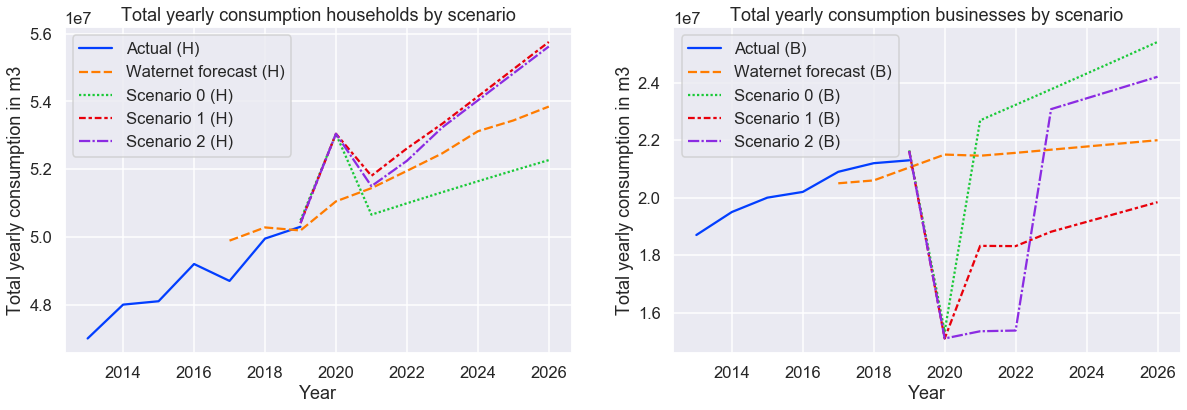

In [239]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(data=df_predicted[['Actual (H)', 'Waternet forecast (H)', 'Scenario 0 (H)', 'Scenario 1 (H)', 'Scenario 2 (H)']],\
    ax=ax[0], palette='bright')
ax[0].set(xlabel='Year', ylabel='Total yearly consumption in m3',\
    title='Total yearly consumption households by scenario')

sns.lineplot(data=df_predicted[['Actual (B)', 'Waternet forecast (B)', 'Scenario 0 (B)', 'Scenario 1 (B)', 'Scenario 2 (B)']],\
    ax=ax[1], palette='bright')
ax[1].set(xlabel='Year', ylabel='Total yearly consumption in m3',\
    title='Total yearly consumption businesses by scenario')

# Put a legend to the right side
#plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()